File: jupyter/notebooks/tcdiags.vl1991_strflw.ipynb\
Author: Henry R. Winterbottom\
Date: 07 September 2023

Topic: This notebook computes and plots the layer mean tropical cyclone (TC) steering flow as described by Velden and Leslie [1991].

References:

    Velden, C. S., and L. M.Leslie (1991), The basic relationship between tropical cyclone intensity and the depth of the environmental  steering layer in the Australian Region, Weather Forecast., 6, 244–253.


In [1]:
import matplotlib.pyplot as plt
import numpy
import tcmarkers
from confs.yaml_interface import YAML
from mpl_toolkits.basemap import Basemap
from plottools.build_basemap import build_basemap
from plottools.draw_basemap import draw_basemap
from scipy.interpolate import interp1d
from tcdiags.tcdiags import TCDiags
from tools import parser_interface

### User Configuration

In [2]:
# YAML-formatted configuration files.
yaml = "/home/ufs_tcdiags/parm/tcdiags.demo.yaml"

# Plotting attributes.
vmax_cint = 10.0
vmax_cmax = 50.0
vmax_cmin = 0.0
vmax_cmap = "viridis"
levels = numpy.linspace(vmax_cmin, vmax_cmax, 255)
ticks = numpy.arange(vmax_cmin, (vmax_cmax + 0.01), vmax_cint)

strm_dens = 10.0
strm_wdth = 0.1
strm_clr = "black"
strm_sty = "->"
strm_sze = 0.5

marker_kwargs = {
    "markersize": 3,
    "color": "red",
    "linewidth": 0.1,
    "markeredgecolor": "red",
    "zorder": 1,
    "marker": tcmarkers.HU,
}

# Tropical cyclone relative steering levels.
tcstrflw_dict = {
    "shallow": {"plev_bottom": 85000.0, "plev_top": 50000.0},
    "medium": {"plev_bottom": 85000.0, "plev_top": 40000.0},
    "deep": {"plev_bottom": 85000.0, "plev_top": 30000.0},
}

### Compute the layer-mean wind tropical cyclone relative steering.

In [3]:
options_obj = parser_interface.object_define()
options_obj.yaml = yaml
options_obj.tcstrflw = True
tcdiag_obj = TCDiags(options_obj=options_obj)
tcstrflw = tcdiag_obj.run().tcstrflw

2023-09-07 23:35:28 :: WARNING :: utils.schema_interface: Schema optional value derived has not been defined; setting to default value False.
2023-09-07 23:35:28 :: WARNING :: utils.schema_interface: Schema optional value method has not been defined; setting to default value None.
2023-09-07 23:35:28 :: WARNING :: utils.schema_interface: Schema optional value module has not been defined; setting to default value None.
2023-09-07 23:35:28 :: WARNING :: utils.schema_interface: Schema optional value scale_mult has not been defined; setting to default value 1.0.
2023-09-07 23:35:28 :: WARNING :: utils.schema_interface: Schema optional value scale_add has not been defined; setting to default value 0.0.
2023-09-07 23:35:28 :: INFO :: utils.schema_interface: 

+--------------+--------+------------+-----------------+---------------------------------------------+
|   Variable   |  Type  |  Optional  | Default Value   | Assigned Value                              |
+==============+========+=====

In [4]:
# Define the relevant tropical cyclone locations.
tcinfo_obj = YAML().read_yaml(
    yaml_file=YAML().read_yaml(yaml_file=options_obj.yaml, return_obj=True).tcinfo,
    return_obj=True,
)


def plot_tcs(basemap: Basemap) -> None:
    """
    Description
    -----------

    This function plots the tropical cyclone locations.

    Parameters
    ----------

    basemap: Basemap

        An initialized Python Basemap object.

    """
    for tcinfo in vars(tcinfo_obj):
        tcobj = parser_interface.dict_toobject(
            in_dict=parser_interface.object_getattr(object_in=tcinfo_obj, key=tcinfo)
        )
        if tcobj.lon_deg < 0:
            tcobj.lon_deg = tcobj.lon_deg + 360.0
        (tcx, tcy) = basemap(tcobj.lon_deg, tcobj.lat_deg)
        plt.plot(tcx, tcy, **marker_kwargs)


### Plot the layer-mean tropical cyclone relative steering.

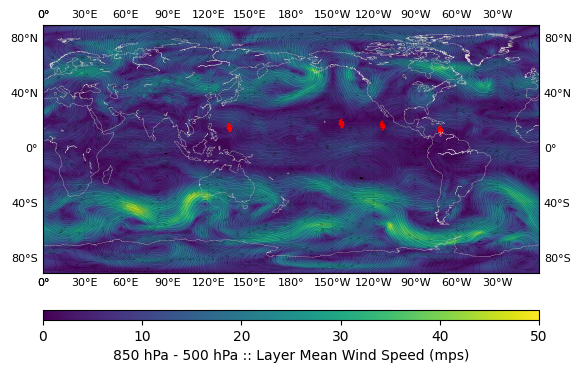

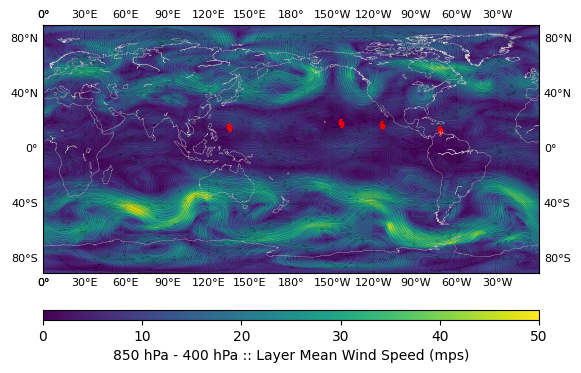

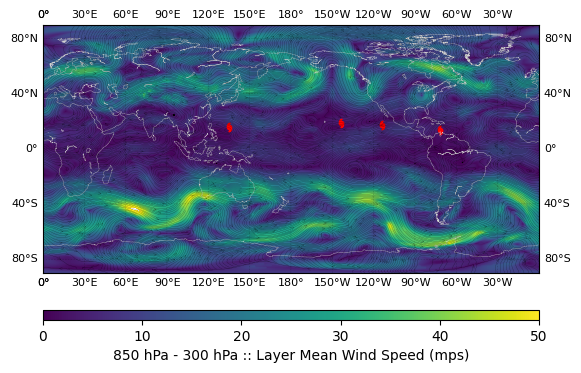

In [5]:
lat = numpy.array(tcstrflw.dims["lat"][1])
xlat = numpy.linspace(-90.0, 90.0, len(lat))
lon = numpy.array(tcstrflw.dims["lon"][1])
xlon = numpy.linspace(0.0, 360.0, len(lon))
(basemap, x, y) = build_basemap(lon=xlon, lat=xlat)

# Define the interpolation attributes.
pressure = numpy.array(tcstrflw.dims["plevs"][1])
dplev = 5000.0
num = 100
uwnd = tcstrflw.uwnd.values
vwnd = tcstrflw.vwnd.values
uinterp_func = interp1d(pressure, uwnd, axis=0, bounds_error=False)
vinterp_func = interp1d(pressure, vwnd, axis=0, bounds_error=False)

for tcstrflw in tcstrflw_dict:
    plev_bottom = parser_interface.dict_key_value(
        dict_in=tcstrflw_dict[tcstrflw], key="plev_bottom"
    )
    plev_top = parser_interface.dict_key_value(
        dict_in=tcstrflw_dict[tcstrflw], key="plev_top"
    )
    plevs = numpy.linspace(plev_bottom, (plev_top - dplev), num=num)
    u = uinterp_func(plevs)
    umean = numpy.nanmean(u[:-1, ...], axis=0)
    v = vinterp_func(plevs)
    vmean = numpy.nanmean(v[:-1, ...], axis=0)
    wndmean = numpy.sqrt(umean * umean + vmean * vmean)
    draw_basemap(basemap=basemap)
    basemap.contourf(x, y, wndmean, levels=levels, cmap=vmax_cmap)
    basemap.streamplot(
        x,
        y,
        umean,
        vmean,
        density=strm_dens,
        linewidth=strm_wdth,
        color=strm_clr,
        arrowstyle=strm_sty,
        arrowsize=strm_sze,
        zorder=10,
    )
    plt.colorbar(
        orientation="horizontal",
        ticks=ticks,
        pad=0.1,
        aspect=50,
        label=f"{int(plev_bottom/100.)} hPa - {int(plev_top/100.)} hPa :: Layer Mean Wind Speed (mps)",
    )
    plot_tcs(basemap=basemap)
    plt.savefig(
        f"tcstrflw.{tcstrflw}.png", dpi=500, transparent=False, bbox_inches="tight"
    )
    plt.show()
